# Data Visualization

# Imports

In [2]:
import ibmdbpy
from ibmdbpy import IdaDataBase, IdaDataFrame
import brunel
import math
from datetime import datetime
import pandas as pd
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')
from my_udfs import *
%matplotlib inline

# Read in Dataframe from Data Preparation Step

In [7]:
# Verify read
spark_loan_sub_kp_df = spark.read.parquet("home/lending_club/loan_sub_kp")
loan_sub_kp = spark_loan_sub_kp_df.toPandas()

In [9]:
loan_sub_kp.head()

,LOAN_STATUS,ISSUE_D,LOAN_AMNT,EMP_TITLE,EMP_LENGTH,VERIFICATION_STATUS,HOME_OWNERSHIP,ANNUAL_INC,PURPOSE,INQ_LAST_6MTHS,DESC,OPEN_ACC,PUB_REC,REVOL_UTIL,DTI,TOTAL_ACC,DELINQ_2YRS,EARLIEST_CR_LINE,MTHS_SINCE_LAST_DELINQ,ADDR_STATE,TERM,DEFAULT,EMP_LISTED,EMPTY_DESC,EMP_NA,DELING_EVER,TIME_HISTORY
0,Current,1320105600000000000,35000,Roto-Rooter Services Company,10+ years,Verified,MORTGAGE,135000,debt_consolidation,2,Borrower added on 10/26/11 > I am consolidat...,13,0,73.1,20.21,31,0,791596800000000000,NaN,KY,60 months,0,1,0,0,0,6117
1,Fully Paid,1270080000000000000,12000,Spec Wheels Of America,5 years,Verified,RENT,32000,debt_consolidation,1,None,8,1,85.7,11.78,29,0,817776000000000000,NaN,CO,36 months,0,1,1,0,0,5235
2,Fully Paid,1262304000000000000,25000,New York University,10+ years,Not Verified,RENT,55164,house,1,Borrower added on 01/11/10 > I am looking fo...,2,0,0.0,0.00,4,0,922924800000000000,NaN,NY,36 months,0,1,0,0,0,3928
3,Fully Paid,1262304000000000000,10000,Boeing,10+ years,Verified,MORTGAGE,92000,small_business,1,None,11,0,30.7,6.89,38,0,794016000000000000,NaN,AL,36 months,0,1,1,0,0,5420
4,Fully Paid,1262304000000000000,23000,TransUnion,1 year,Verified,MORTGAGE,106050,debt_consolidation,3,Borrower added on 01/10/10 > Consolidating 3 c...,14,0,38.2,8.37,40,1,770428800000000000,7,IL,36 months,0,1,0,0,1,5693


# Exploratory Data Analysis

In this section, we will draw some visualizations using the brunel library to further explore the dataset.

* The Growth of Lending Club
* Outcome Variable: Loan Status
* Who Borrowed Most of the Money?
* Default Rate By State
* Loan Purpose
* Credit History(DELING_EVER)
* DTI

## The Growth of Lending Club
### Here we use the builtin Brunel Visualization graphics package

Lending club has been expanding over the years in terms of total loan volume and average loan size.

In [10]:
loan_stats = pd.concat([loan_sub_kp.groupby('ISSUE_D').mean()['LOAN_AMNT'].to_frame().rename(columns = {'LOAN_AMNT':'loan_average'}), loan_sub_kp.groupby('ISSUE_D')['LOAN_STATUS'].count().to_frame().rename(columns = {'LOAN_STATUS':'loan_count'})], axis=1)

In [11]:
%brunel data('loan_stats') line x(ISSUE_D) y(loan_average, loan_count) color(#series) tooltip(#all) :: width=900, height=350 

<IPython.core.display.Javascript object>

## Outcome Variable: Loan Status
On the left is the breakdown of all loan status classifications.  On the right is our simple default classification based on our data prep

In [6]:
%brunel data('loan_sub_kp') bar x(LOAN_STATUS) y(#count:linear) color(LOAN_STATUS) tooltip(#all) | stack polar bar y(#count) color(DEFAULT) percent(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

## Who Borrowed Most of the Money?

Most of the money in terms of absolute borrowing is borrowed by people from California. For average loan amount per state, Alaska ranks on top.

In [9]:
state_stats = pd.concat([loan_sub_kp.groupby('ADDR_STATE').sum()['LOAN_AMNT'].to_frame().rename(columns = {'LOAN_AMNT':'state_total'}), loan_sub_kp.groupby('ADDR_STATE').mean()['LOAN_AMNT'].to_frame().rename(columns = {'LOAN_AMNT':'state_mean'})], axis=1)

In [11]:
%brunel data('state_stats') map color(state_total:[blues, reds]) key(ADDR_STATE) label(ADDR_STATE) tooltip(#all) title("Total Loan Amount by State") style('.header {label-location:left}')| map color(state_mean:[blues, reds]) key(ADDR_STATE) label(ADDR_STATE) tooltip(#all) title("Average Loan Amount by State") style('.header {label-location:left}') :: width=1200, height=350 

<IPython.core.display.Javascript object>

## Default Rate By State

Most states has a default rate under 20%. But the default rate of Nebraska(NE) is 60% since it has 5 loan applications in total and 3 of them are charged off.  

In [12]:
default_rate = loan_sub_kp.groupby('ADDR_STATE').mean()['DEFAULT'].to_frame().rename(columns = {'DEFAULT':'DEFAULT_RATE'})

In [13]:
%brunel data('default_rate') map color(DEFAULT_RATE:[blues, reds]) key(ADDR_STATE) label(ADDR_STATE) tooltip(#all) title("Default Rate by State")

<IPython.core.display.Javascript object>

## Loan Purpose

Most loans are used for debt consolidation.

In [14]:
purpose_count = loan_sub_kp.groupby('PURPOSE')['LOAN_STATUS'].count().to_frame().rename(columns = {'LOAN_STATUS':'COUNT'})

In [15]:
%brunel bubble data('purpose_count') color(COUNT:[blues, reds]) size(COUNT) label(PURPOSE) tooltip(#all)

<IPython.core.display.Javascript object>

## DTI(debt-to-income ratio)

A debt-to-income ratio (DTI) is one way lenders (including mortgage lenders) measure an individual's ability to manage monthly payment and repay debts. A low debt-to-income ratio demonstrates a good balance between debt and income. Conversely, a high DTI can signal that an individual has too much debt for the amount of income he or she has. As the plot below shows, borrowers who default on their loans have higher DTI than those who did not default.

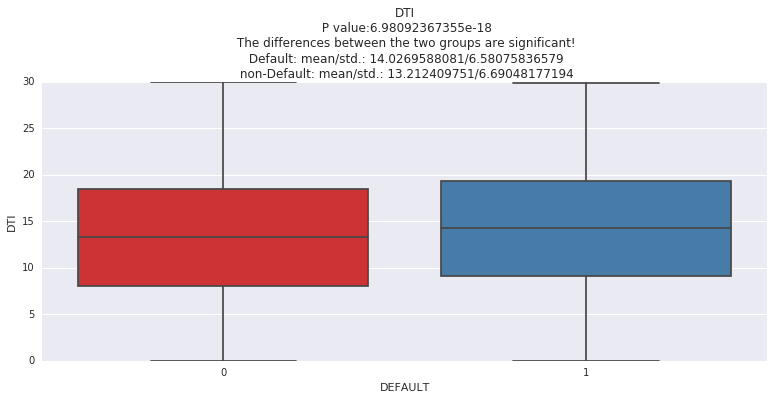

In [5]:
plot_boxplot(loan_sub_kp, ['DTI'])